In [88]:
!pip install rdkit-pypi

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import SaltRemover, MolFromSmiles, Draw, GetFormalCharge, MolToSmiles
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import rdFingerprintGenerator
from statistics import mean

### Dataset 1 (https://github.com/theochem/B3DB)

In [90]:
data_1 = pd.read_csv('B3DB.tsv', sep='\t')
data_1.head()

,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,BBB+/BBB-,Inchi,threshold,reference,group,comments
0,1,sulphasalazine,2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,5339.0,-2.69,BBB-,InChI=1S/C18H14N4O5S/c23-16-9-6-13(11-15(16)18...,NaN,R2|R2|R25|R46|,A,NaN
1,2,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,3889.0,-2.52,BBB-,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,NaN,R25|,A,NaN
2,3,clioquinol,5-chloro-7-iodoquinolin-8-ol,Oc1c(I)cc(Cl)c2cccnc12,2788.0,-2.40,BBB-,InChI=1S/C9H5ClINO/c10-6-4-7(11)9(13)8-5(6)2-1...,NaN,R18|R26|R27|,A,NaN
3,4,bbcpd11 (cimetidine analog) (y-g13),2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...,CCNC(=NCCSCc1ncccc1Br)NC#N,14022517.0,-2.15,BBB-,InChI=1S/C12H16BrN5S/c1-2-15-12(18-9-14)17-6-7...,NaN,R2|R2|R8|R40|R2|R2|R2|R2|R18|R21|R25|R25|R26|R...,A,NaN
4,5,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,18595497.0,-2.15,BBB-,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,NaN,R25|,A,NaN


In [91]:
Chem.CanonSmiles(data_1.iloc[0]['SMILES'])

'O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O'

In [92]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7807 entries, 0 to 7806
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NO.            7807 non-null   int64  
 1   compound_name  6698 non-null   object 
 2   IUPAC_name     6170 non-null   object 
 3   SMILES         7807 non-null   object 
 4   CID            6170 non-null   float64
 5   logBB          1058 non-null   float64
 6   BBB+/BBB-      7807 non-null   object 
 7   Inchi          7807 non-null   object 
 8   threshold      3621 non-null   float64
 9   reference      7807 non-null   object 
 10  group          7807 non-null   object 
 11  comments       18 non-null     object 
dtypes: float64(3), int64(1), object(8)
memory usage: 732.0+ KB


In [93]:
data_1 = data_1[['SMILES', 'logBB']]


In [94]:
data_1['SMILES'] = data_1['SMILES'].apply(lambda smi: Chem.CanonSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(smi))))

In [95]:
data_1.head()

,SMILES,logBB
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,-2.69
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,-2.52
2,Oc1c(I)cc(Cl)c2cccnc12,-2.40
3,CCNC(=NCCSCc1ncccc1Br)NC#N,-2.15
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,-2.15


In [96]:
data_1['logBB'] = data_1['logBB'].fillna(-1e9)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7807 entries, 0 to 7806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  7807 non-null   object 
 1   logBB   7807 non-null   float64
dtypes: float64(1), object(1)
memory usage: 122.1+ KB


In [97]:
data_1 = data_1[data_1['logBB'] > -1e9]
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 0 to 1057
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  1058 non-null   object 
 1   logBB   1058 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.8+ KB


In [98]:
len(data_1['SMILES'].unique())

1058

In [99]:
data_1 = data_1.rename(columns={'SMILES':'SMILES', 'logBB':'Activity'})
data_1.head()

,SMILES,Activity
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,-2.69
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,-2.52
2,Oc1c(I)cc(Cl)c2cccnc12,-2.40
3,CCNC(=NCCSCc1ncccc1Br)NC#N,-2.15
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,-2.15


In [100]:
data_1.drop_duplicates()

,SMILES,Activity
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,-2.69
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,-2.52
2,Oc1c(I)cc(Cl)c2cccnc12,-2.40
3,CCNC(=NCCSCc1ncccc1Br)NC#N,-2.15
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,-2.15
...,...,...
1053,CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1,1.53
1054,CN[C@H]1CC[C@@H](c2ccc(Cl)c(Cl)c2)c2ccccc21,1.60
1055,CNC1CCC(c2ccc(Cl)c(Cl)c2)c2ccccc21,1.60
1056,FC(F)(F)c1ccc(N2CCNCC2)nc1Cl,1.64


In [101]:
data_1.describe()

,Activity
count,1058.000000
mean,-0.077873
std,0.751623
min,-2.690000
25%,-0.535000
50%,-0.020000
75%,0.420000
max,1.700000


### Dataset 2 (https://github.com/znavoyan/vae-embeddings/, article: https://doi.org/10.1186/s13321-022-00648-x)

In [102]:
data_2 = pd.read_csv('final_logBB_2967.csv')
data_2.head()

,InchiKey,smiles,new_logBB,new_BBclass,canon_smiles
0,AABLHGPVOULICI-UHFFFAOYSA-N,CN1CCC24C3Oc5c(O)ccc(CC1C2(O)CCC3O)c45,NaN,1,CN1CCC23c4c5ccc(O)c4OC2C(O)CCC3(O)C1C5
1,AAOVKJBEBIDNHE-UHFFFAOYSA-N,c1c(Cl)ccc(c12)N(C)C(=O)CN=C2c3ccccc3,0.330807,1,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21
2,AAQOQKQBGPPFNS-UHFFFAOYSA-N,CC[N+](C)(C)CC=1C=CC=CC=1[Br],NaN,0,CC[N+](C)(C)Cc1ccccc1Br
3,AAXVEMMRQDVLJB-UHFFFAOYSA-N,CC34CC(O)C1(F)C(CCC2=CC(=O)CCC12C)C3CCC4(O)C(=...,NaN,1,CC12CCC(=O)C=C1CCC1C3CCC(O)(C(=O)CO)C3(C)CC(O)...
4,ABQYZRZVRIPTPI-UHFFFAOYSA-M,COn1cc(C(=O)[O-])c(=O)c2cc3c(cc21)OCO3,-0.920500,1,COn1cc(C(=O)[O-])c(=O)c2cc3c(cc21)OCO3


In [103]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2967 entries, 0 to 2966
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   InchiKey      2967 non-null   object 
 1   smiles        2967 non-null   object 
 2   new_logBB     978 non-null    float64
 3   new_BBclass   2967 non-null   int64  
 4   canon_smiles  2967 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 116.0+ KB


In [104]:
data_2 = data_2[['canon_smiles', 'new_logBB']]

In [105]:
data_2 = data_2.rename(columns={'canon_smiles':'SMILES', 'new_logBB':'Activity'})
data_2.head()

,SMILES,Activity
0,CN1CCC23c4c5ccc(O)c4OC2C(O)CCC3(O)C1C5,NaN
1,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,0.330807
2,CC[N+](C)(C)Cc1ccccc1Br,NaN
3,CC12CCC(=O)C=C1CCC1C3CCC(O)(C(=O)CO)C3(C)CC(O)...,NaN
4,COn1cc(C(=O)[O-])c(=O)c2cc3c(cc21)OCO3,-0.920500


In [106]:
data_2['Activity'] = data_2['Activity'].fillna(-1e9)
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2967 entries, 0 to 2966
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    2967 non-null   object 
 1   Activity  2967 non-null   float64
dtypes: float64(1), object(1)
memory usage: 46.5+ KB


In [107]:
data_2 = data_2[data_2['Activity'] > -1e9]
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978 entries, 1 to 2966
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    978 non-null    object 
 1   Activity  978 non-null    float64
dtypes: float64(1), object(1)
memory usage: 22.9+ KB


In [108]:
data_2['Activity'] = data_2['Activity'].apply(lambda x: round(x, 2))

<ipython-input-108-249286af5b9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['Activity'] = data_2['Activity'].apply(lambda x: round(x, 2))


In [109]:
data_1_smiles = data_1['SMILES'].tolist()
data_2_smiles = data_2['SMILES'].tolist()

In [110]:
smiles_both = []

for smi in data_2_smiles:
    if smi in data_1_smiles:
        smiles_both.append(smi)
len(smiles_both)

653

In [111]:
only_data_2_smiles = list(set(data_2_smiles) - set(smiles_both))
len(only_data_2_smiles)

325

In [112]:
# delete extra rows from data_2 (those that presented in data_1)
for i, row in data_2.iterrows():
    if row.SMILES in smiles_both:
        data_2 = data_2.drop(labels=[i], axis=0)
len(data_2)

325

### Merge

In [113]:
final_data = pd.concat([data_1, data_2], ignore_index=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    1383 non-null   object 
 1   Activity  1383 non-null   float64
dtypes: float64(1), object(1)
memory usage: 21.7+ KB


In [114]:
final_data.describe()

,Activity
count,1383.000000
mean,-0.200615
std,1.720540
min,-25.320000
25%,-0.595000
50%,-0.020000
75%,0.445000
max,1.700000


<Axes: >

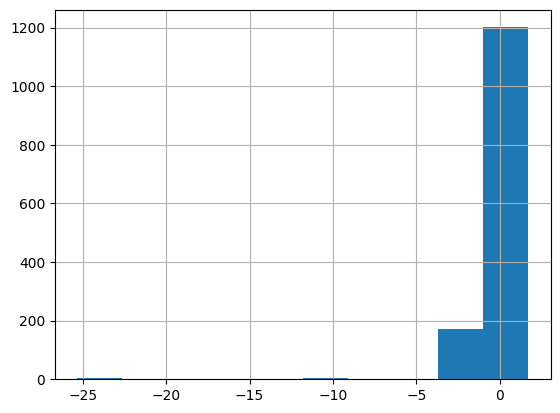

In [115]:
final_data['Activity'].hist()

<Axes: xlabel='Activity'>

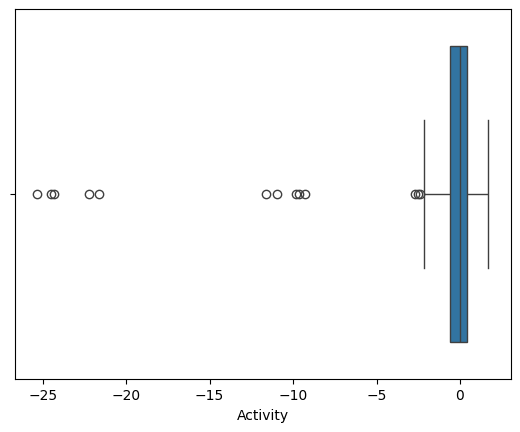

In [116]:
sns.boxplot(x=final_data['Activity'])

In [117]:
lower_bound = -0.203686 - 1.733203 * 3
upper_bound = -0.203686 + 1.733203 * 3
print(lower_bound)
print(upper_bound)

-5.403295000000001
4.995923


In [118]:
# delete primary outliers
for i, row in final_data.iterrows():
    if row.Activity < lower_bound or row.Activity > upper_bound:
        final_data = final_data.drop(labels=[i], axis=0)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1373 entries, 0 to 1382
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    1373 non-null   object 
 1   Activity  1373 non-null   float64
dtypes: float64(1), object(1)
memory usage: 32.2+ KB


In [119]:
final_data.describe()

,Activity
count,1373.000000
mean,-0.078704
std,0.768697
min,-2.690000
25%,-0.570000
50%,-0.010000
75%,0.460000
max,1.700000


<Axes: xlabel='Activity'>

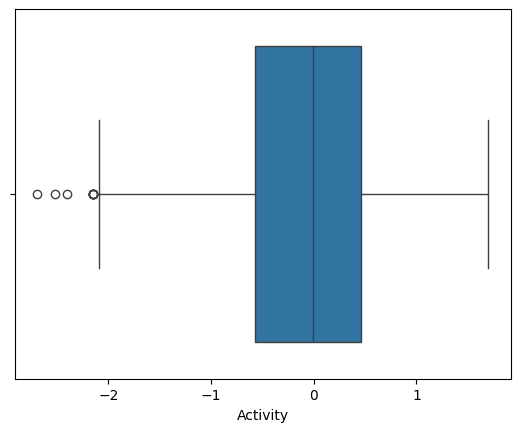

In [120]:
sns.boxplot(x=final_data['Activity'])

In [121]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1373 entries, 0 to 1382
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    1373 non-null   object 
 1   Activity  1373 non-null   float64
dtypes: float64(1), object(1)
memory usage: 32.2+ KB


In [122]:
final_data.to_csv('final_dataset_logbb.csv',index=False)

### **Remove charge**

In [123]:
un = rdMolStandardize.Uncharger()

In [124]:
filename = 'final_dataset_logbb.csv'
df = pd.read_csv(filename)
df.shape

(1373, 2)

In [125]:
df['Agglomeration'] = df['SMILES'].apply(lambda x: '.' in x)
df['SMILES_clear'] = df['SMILES'].apply(lambda x: max(x.split('.'), key=len))
df['ROMol'] = df['SMILES_clear'].apply(lambda x: MolFromSmiles(x))
print(df.shape)
df = df[~df["ROMol"].isna()]
df.shape

(1373, 5)


(1373, 5)

In [126]:
df['FORMAL_CHARGE_ch'] = df['SMILES_clear'].apply(lambda x: GetFormalCharge(MolFromSmiles(x)))
df['SMILES_uncharge'] = df['ROMol'].apply(lambda x: MolToSmiles(un.uncharge(x), kekuleSmiles=True))
df['FORMAL_CHARGE_unch'] = df['SMILES_uncharge'].apply(lambda x: GetFormalCharge(MolFromSmiles(x)))

[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Running Uncharger
[17:55:05] Run

In [127]:
df.drop(labels=['SMILES_clear', 'ROMol', 'FORMAL_CHARGE_ch'], inplace=True, axis=1)

In [128]:
df['FORMAL_CHARGE_unch'].describe()

,FORMAL_CHARGE_unch
count,1373.000000
mean,0.011653
std,0.113946
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [129]:
df.reset_index(drop=True, inplace=True)

In [130]:
df.to_csv(f'{filename[:-4]}_mod.csv', index=False)

### **Remove inorganic molecules**

In [131]:
df = pd.read_csv('final_dataset_logbb_mod.csv')

In [132]:
df.shape

(1373, 5)

In [133]:
df_charged = df[df['FORMAL_CHARGE_unch'] != 0]

In [134]:
df_charged.shape

(15, 5)

In [135]:
df_charged.head(5)

,SMILES,Activity,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch
59,NCc1c[n+]2ccccc2[nH]1,-1.40,False,NCC1=C[N+]2=CC=CC=C2N1,1
108,CCCCCCCCCCCCCCCCOP(=O)(O)OCC[N+](C)(C)C,-1.14,False,CCCCCCCCCCCCCCCCOP(=O)(O)OCC[N+](C)(C)C,1
138,COc1cc(N)cn[n+]1-c1ccccc1,-1.00,False,COC1=CC(N)=CN=[N+]1C1=CC=CC=C1,1
190,Cc1c(CCOC(=O)c2cc(=O)c3c(Cl)cc(Cl)cc3[nH]2)sc[...,-0.78,False,CC1=C(CCOC(=O)C2=CC(=O)C3=C(Cl)C=C(Cl)C=C3N2)S...,1
201,Cc1cn(C2CC(N=[N+]=N)C(CO)O2)c(=O)[nH]c1=O,-0.72,False,CC1=CN(C2CC(N=[N+]=N)C(CO)O2)C(=O)NC1=O,1


In [136]:
index_sm = df.index.tolist()

In [137]:
print(index_sm[:5])

[0, 1, 2, 3, 4]


In [138]:
sm = df['SMILES_uncharge'].values
sm

array(['O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C=C2)=CC=C1O',
       'COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(=O)O)=C(CSC3=NN=NN3C)COC21',
       'OC1=C(I)C=C(Cl)C2=CC=CN=C12', ...,
       'CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(=O)C2=CC=CC=C2)C2(O)CC(OC(=O)C(O)C(NC(=O)C3=CC=C(F)C=C3)C3=CC=CC=C3)C(C)=C1C2(C)C',
       'COC1=CC=C(C(C)C)C=C1CNC1CCCNC1C1=CC=CC=C1',
       'CN(C)CCOC(C1=CC=CC=C1)C1=CC=CC=C1'], dtype=object)

In [139]:
cl = df[df['SMILES_uncharge'] == '[O-][Cl+3]([O-])([O-])O']
cl

,SMILES,Activity,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch


In [140]:
list_inorg_el = ['Al', 'Au', 'Ar,''Ba', 'Be', 'Bi', 'Ca','Cd', 'Co','Cr','Cu','Fe', 'Gd','Ge', 'Hf',
                 'Hg', 'In', 'K', 'Kr' 'La', 'Mg', 'Mn', 'Na', 'Ni', 'Pb', 'Pt', 'Sb', 'Sn','Sr','Te',
                 'V','Zn', 'Li', 'Xe', 'Rn', 'Ne']
index_drop = []
uniq_el = set([])
for sm_i in range(len(sm)):
    mol_sm = MolFromSmiles(sm[sm_i])
    list_at = [str(x.GetSymbol()) for x in mol_sm.GetAtoms()]
    intersec = list(set(list_at) & set(list_inorg_el))
    T_C = 'C' in list_at
    if T_C == False:
        index_drop.append(index_sm[sm_i])
        print('smiles', sm[sm_i])
    elif len(intersec) > 0:
        index_drop.append(index_sm[sm_i])
        print('intersection', intersec)
    uniq_el = uniq_el | set(list_at)


smiles [Li]
smiles [Kr]
smiles O
smiles N#N
smiles [Ar]
smiles [N-]=[N+]=O
smiles N#[N+]O
smiles NN
smiles [Xe]
smiles [Ne]
smiles FS(F)(F)(F)(F)F
smiles N#[N+][O-]
smiles [Rn]


In [141]:
uniq_el

{'Ar',
 'B',
 'Br',
 'C',
 'Cl',
 'F',
 'I',
 'Kr',
 'Li',
 'N',
 'Ne',
 'O',
 'P',
 'Rn',
 'S',
 'Xe'}

In [142]:
index_drop

[357, 436, 520, 568, 569, 570, 572, 573, 574, 674, 777, 1121, 1286]

In [143]:
len(index_drop)

13

In [144]:
df.drop(index=index_drop, inplace=True)

In [145]:
df.describe()

,Activity,FORMAL_CHARGE_unch
count,1360.000000,1360.000000
mean,-0.079596,0.011029
std,0.772150,0.111299
min,-2.690000,0.000000
25%,-0.590000,0.000000
50%,-0.020000,0.000000
75%,0.460000,0.000000
max,1.700000,2.000000


In [146]:
df[df['FORMAL_CHARGE_unch'] == 5]

,SMILES,Activity,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch


In [147]:
df[df['FORMAL_CHARGE_unch'] == -1]

,SMILES,Activity,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch


In [148]:
df[df['FORMAL_CHARGE_unch'] == -1]

,SMILES,Activity,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch


In [149]:
len(df.duplicated(subset=['SMILES_uncharge'], keep=False))

1360

In [150]:
df_dupl = df[df.duplicated(subset=['SMILES_uncharge'], keep=False)]
df_dupl = df_dupl.sort_values(by=['SMILES_uncharge'])
df_dupl.to_csv('BBB_dupl.csv', index=False)
df_dupl

,SMILES,Activity,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch
1310,Brc1cc(Br)c(NC2=[NH+]CCN2)c(Br)c1,0.58,False,BrC1=CC(Br)=C(NC2=NCCN2)C(Br)=C1,0
853,Brc1cc(Br)c(NC2=NCCN2)c(Br)c1,0.58,False,BrC1=CC(Br)=C(NC2=NCCN2)C(Br)=C1,0
738,Brc1cccc(Br)c1NC1=NCCN1,0.33,False,BrC1=CC=CC(Br)=C1NC1=NCCN1,0
1332,Brc1cccc(Br)c1NC1=[NH+]CCN1,0.33,False,BrC1=CC=CC(Br)=C1NC1=NCCN1,0
1307,c1cc(C[NH+]2CCCCC2)cc(OCCCNc2nc3ccccc3o2)c1,0.22,False,C1=CC(CN2CCCCC2)=CC(OCCCNC2=NC3=CC=CC=C3O2)=C1,0
...,...,...,...,...,...
529,OCCCOc1cccc(CN2CCCCC2)c1,-0.02,False,OCCCOC1=CC=CC(CN2CCCCC2)=C1,0
1234,OCC[NH+]1CC[NH+](CCCN2c3ccccc3Sc3ccc(C(F)(F)F)...,1.52,False,OCCN1CCN(CCCN2C3=CC=CC=C3SC3=CC=C(C(F)(F)F)C=C...,0
1052,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1,1.50,False,OCCN1CCN(CCCN2C3=CC=CC=C3SC3=CC=C(C(F)(F)F)C=C...,0
1368,OCCOCC[NH+]1CC[NH+](C(c2ccccc2)c2ccc(Cl)cc2)CC1,0.28,False,OCCOCCN1CCN(C(C2=CC=CC=C2)C2=CC=C(Cl)C=C2)CC1,0


In [151]:
df.drop_duplicates(subset=['SMILES_uncharge'], inplace=True)

In [152]:
df

,SMILES,Activity,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch
0,O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O,-2.69,False,O=C(O)C1=CC(N=NC2=CC=C(S(=O)(=O)NC3=CC=CC=N3)C...,0
1,COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...,-2.52,False,COC1(NC(=O)C(C(=O)O)C2=CC=C(O)C=C2)C(=O)N2C(C(...,0
2,Oc1c(I)cc(Cl)c2cccnc12,-2.40,False,OC1=C(I)C=C(Cl)C2=CC=CN=C12,0
3,CCNC(=NCCSCc1ncccc1Br)NC#N,-2.15,False,CCNC(=NCCSCC1=NC=CC=C1Br)NC#N,0
4,CN1CC[C@]23c4c5ccc(OC6O[C@H](C(=O)O)[C@@H](O)[...,-2.15,False,CN1CC[C@]23C4=C5C=CC(OC6O[C@H](C(=O)O)[C@@H](O...,0
...,...,...,...,...,...
1354,Clc1cc(Br)cc(Cl)c1N=C1NCCN1,0.41,False,ClC1=CC(Br)=CC(Cl)=C1N=C1NCCN1,0
1362,O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1,-1.83,False,O=C(O)COCCN1CCN(C(C2=CC=CC=C2)C2=CC=C(Cl)C=C2)CC1,0
1364,CC(Nc1cc(-c2c(-c3cccc(C(F)(F)F)c3)nc(C3CCNCC3)...,0.01,False,CC(NC1=CC(C2=C(C3=CC=CC(C(F)(F)F)=C3)N=C(C3CCN...,0
1365,CC(C)CC1C(=O)N2CCCC2C2OC(NC(=O)C3C=C4c5cccc6[n...,-0.59,False,CC(C)CC1C(=O)N2CCCC2C2OC(NC(=O)C3C=C4C5=CC=CC6...,0


In [153]:
df.shape

(1178, 5)

In [154]:
df = df.reset_index(drop=True)

In [155]:
df[df.Activity < -1.99].shape

(16, 5)

In [156]:
df[df.Activity < -1].shape

(152, 5)

In [157]:
df[df.Activity > 1].shape

(61, 5)

In [158]:
df[df.Activity > 1.39].shape

(13, 5)

In [159]:
mean_ac = df.Activity.mean()
mean_ac

-0.11056876061120544

In [160]:
std_ac = df.Activity.std()
std_ac

0.7613016616242445

In [161]:
mean_ac - 2 * std_ac

-1.6331720838596944

In [162]:
df[df.Activity < -1.633].shape

(38, 5)

In [163]:
mean_ac + 2 * std_ac

1.4120345626372837

In [164]:
df[df.Activity > 1.41].shape

(10, 5)

In [165]:
df = df[(df.Activity < (mean_ac + 2 * std_ac)) & (df.Activity > (mean_ac - 2 * std_ac))]
df.shape

(1130, 5)

In [166]:
df.to_csv('regression_dataset_without_descriptors.csv', index=False)